# Blood Glucose Control - EDA

**Name:** *Hanyu Yao*



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [106]:
import pandas as pd
import os
from datetime import datetime

data_folder_path = os.path.join("..", "data")

# find all csv files in the data folder
csv_files = [f for f in os.listdir(data_folder_path) if f.endswith(".csv")]

# init an empty list to hold all the individual datasets
df_list = []

# load each csv file and add identifier
for i, csv_file_name in enumerate(csv_files):
    df = pd.read_csv(os.path.join(data_folder_path, csv_file_name), dtype={'date': str})
    # print(df['date'])
    pwd = csv_file_name.split('_')[1].replace('.csv', '')
    df['pwd'] = pwd
    # format the date to the form '%Y-%m-%d %H:%M:%S-%z'
    df['date'] = df['date'].apply(lambda dt: pd.to_datetime(dt[:19] + dt[-6:], format='%Y-%m-%d %H:%M:%S%z'))
    # print(df['date'])
    df_list.append(df)
    
# put all DataFrames into a single dataframe
dataframes = pd.concat(df_list, ignore_index=True)
# # enable automatic inferrence for date format
dataframes['date'] = pd.to_datetime(dataframes['date'], format='%Y-%m-%d %H:%M:%S%z', utc=True)

# print
print(dataframes.info())
# print(dataframes.head())
# print(dataframes.tail())

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59912 entries, 0 to 59911
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  59912 non-null  datetime64[ns, UTC]
 1   sender_id             2312 non-null   float64            
 2   bgl                   59587 non-null  float64            
 3   bgl_date_millis       2268 non-null   float64            
 4   text                  2297 non-null   object             
 5   template              116 non-null    object             
 6   msg_type              2312 non-null   object             
 7   affects_fob           2312 non-null   object             
 8   affects_iob           2312 non-null   object             
 9   dose_units            1117 non-null   float64            
 10  food_g                1005 non-null   float64            
 11  food_glycemic_index   995 non-null    float64            
 12  dose

### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

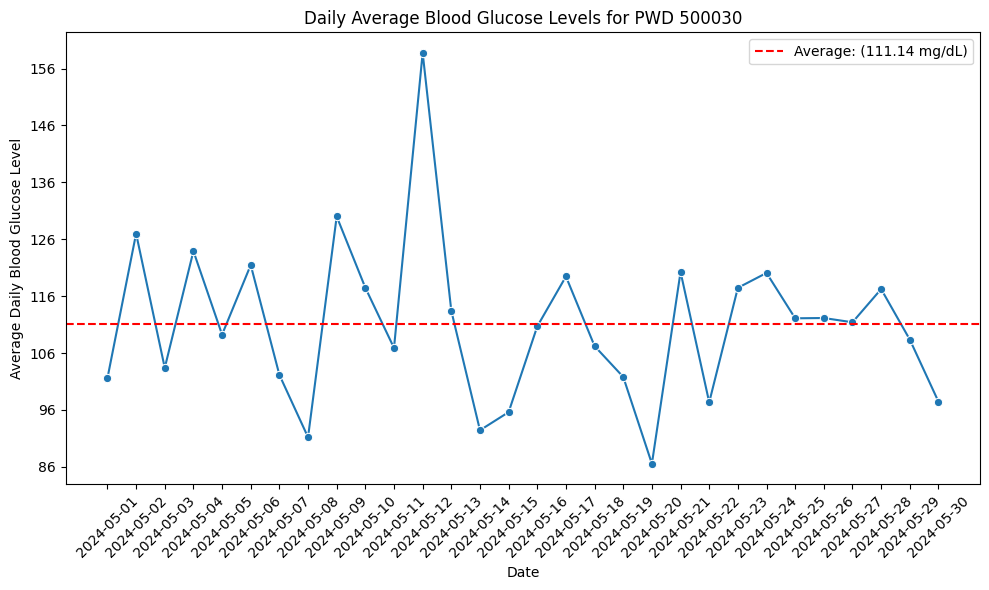

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

"""
    
    1. The daily average blood glucose levels of a patient within some time range
    
    The code provides a visual representation of the blood glucose levels for a specific patient (500030 for demo purpose)
    over some period (one month for demo purpose). 
    It helps in understanding how the average glucose levels fluctuate daily, which can be useful for monitoring and 
    adjusting treatment plans.

"""


PWD_FOR_PLOT = '500030'
START_DATE_FOR_PLOT_1 = pd.to_datetime("2024-05-01 05:00:27+00:00")
END_DATE_FOR_PLOT_1 = pd.to_datetime("2024-05-30 05:00:27+00:00")

def filter_by_pwd(df, pwd):
    return df[df['pwd'] == pwd]
    
def calculate_daily_avg_bgl(filtered_df, start_date, end_date):
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['date']):
        filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')
        
    # Filter for the specific date range
    weekly_data = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]
    # Group by date (day) and calculate the daily average of 'bgl'
    daily_avg_bgl = weekly_data.groupby(weekly_data['date'].dt.date)['bgl'].mean().reset_index(name='avg_bgl')
    
    return daily_avg_bgl

def plot_bgl_changes(figsize, data, x_label, y_label, plot_title):
    mean = data['avg_bgl'].mean()
    
    plt.figure(figsize=figsize)

    sns.lineplot(x='date', y='avg_bgl', data=data, marker='o')
    # plot the average and the normal upper bound
    plt.axhline(y=mean, linestyle='--', color='r', label=f'Average: ({mean:.2f} mg/dL)')
    
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.xticks(pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D'), rotation=45)
    plt.yticks(range(int(data['avg_bgl'].min()), int(data['avg_bgl'].max()) + 1, 10))
    plt.tight_layout()

    plt.show()

# Step 1: Filter data by PWD
filtered_df = filter_by_pwd(dataframes, PWD_FOR_PLOT)

# Step 2: Calculate daily average blood glucose level
daily_avg_bgl = calculate_daily_avg_bgl(filtered_df, START_DATE_FOR_PLOT_1, END_DATE_FOR_PLOT_1)

# Step 3: Plot the daily average blood glucose levels
plot_bgl_changes(figsize=(10,6), data=daily_avg_bgl, x_label='Date', y_label='Average Daily Blood Glucose Level', plot_title=f'Daily Average Blood Glucose Levels for PWD {PWD_FOR_PLOT}')
     


From the plot, we can conclude that:

- The average blood glucose level over the specified time period is 111 mg/dL. This is lower the normal upper limit for normal blood glucose, which is still generally considered to be around 125 mg/dL. 

- The plot shows considerable fluctuation in the daily average blood glucose levels. Such variability can indicate:

1. Inconsistent Glycemic Control: Frequent or significant changes in blood glucose levels might suggest that glycemic control is not well managed.

2. Dietary or Medication Factors: Variability could be due to changes in diet, medication adherence, or other factors influencing blood glucose levels.

- Some potential Next Steps: need monitoring and adjustments. If the patient is experiencing significant fluctuation, it may be beneficial to review and adjust their treatment plan, dietary habits, or monitoring practices to improve overall glucose control.

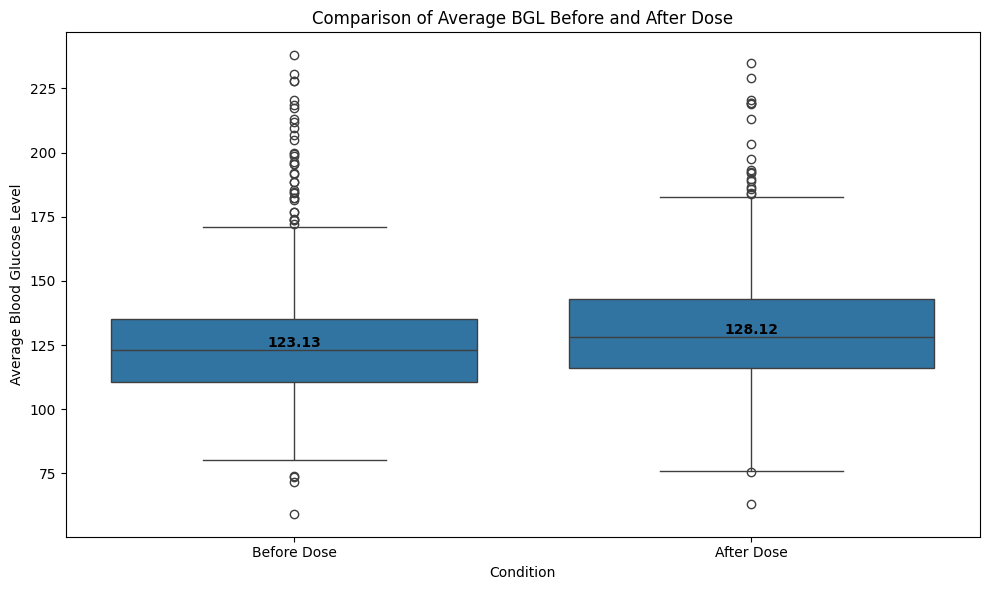

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

"""
    2. The average blood glucose level before and after dosing
    
    The following code analyzes and visualizes the effects of doses on blood glucose levels (BGL).
    Specifically, it compares the average BGL before and after doses to understand the impact of dosing.

"""


HOURS_BEFORE_DOSE = 2
HOURS_AFTER_DOSE = 2

def filter_dose_times(df):
    return df[df['dose_units'].notnull()]

def calculate_bgl_before_after_dose(dose_df, bgl_df, hours_before_dose, hours_after_dose):
    avg_bgl_before_dose = []
    avg_bgl_after_dose = []
    
    for dose_time in dose_df['date']:
        # Filter BGL data for within the time range
        before_dose_data = bgl_df[(bgl_df['date'] <= dose_time) & (bgl_df['date'] > dose_time - pd.Timedelta(hours=hours_before_dose))]
        after_dose_data = bgl_df[(bgl_df['date'] > dose_time) & (bgl_df['date'] <= dose_time + pd.Timedelta(hours=hours_after_dose))]

        # Calculate mean BGL before and after dose
        mean_bgl_before_dose = before_dose_data['bgl'].mean()
        avg_bgl_before_dose.append(mean_bgl_before_dose)

        mean_bgl_after_dose = after_dose_data['bgl'].mean()
        avg_bgl_after_dose.append(mean_bgl_after_dose)
    
    return avg_bgl_before_dose, avg_bgl_after_dose

def plot_bgl_comparison(avg_bgl_before_dose, avg_bgl_after_dose, title):
    plt.figure(figsize=(10, 6))
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'Condition': ['Before Dose'] * len(avg_bgl_before_dose) + ['After Dose'] * len(avg_bgl_after_dose),
        'Average BGL': avg_bgl_before_dose + avg_bgl_after_dose
    })
    
        
    ax = sns.boxplot(x='Condition', y='Average BGL', data=df_plot)
    medians = df_plot.groupby('Condition')['Average BGL'].median()

    for i, condition in enumerate(df_plot['Condition'].unique()):
        median_value = medians[condition]
        ax.text(i, median_value, f'{median_value:.2f}', 
                horizontalalignment='center', 
                verticalalignment='bottom', 
                color='black', 
                fontsize=10, 
                weight='bold')
    
    plt.title(title)
    plt.xlabel('Condition')
    plt.ylabel('Average Blood Glucose Level')
    plt.tight_layout()
    
    plt.show()

# Step 1: Filter data for doses
dose_df = filter_dose_times(dataframes)

# Step 2: Calculate average BGL before and after the dose
avg_bgl_before_dose, avg_bgl_after_dose = calculate_bgl_before_after_dose(dose_df, dataframes, HOURS_BEFORE_DOSE, HOURS_AFTER_DOSE)

# Step 3: Plot the comparison of average BGL before and after the dose
plot_bgl_comparison(avg_bgl_before_dose, avg_bgl_after_dose, title=f'Comparison of Average BGL Before and After Dose')



From the above plot, we can conclude that:

- Effectiveness of Dosing: There is a noticeable difference in the average blood glucose levels before and after the dose. 
Specifically, if the median BGL after dosing is significantly different from the median BGL before dosing, this could indicate that the dose has a substantial impact on glucose regulation.

- Some further thoughts: The results encourage further investigation into the specific types of doses and their individual impacts. Adjustments to dosing strategies might be necessary to achieve better glucose control.

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. Are there specific patterns or best practices for timing doses to optimize blood glucose control?
2. Can we build a model to perdict the blood glucose level after intaking the food that has food_glycemic_index and weights food_g?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`